In [1]:
import os
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt

# For multiprocessing
import multiprocessing # os.cpu_count() = 8
import itertools

# For Hamiltonian
import quantumxy.quantumxy as qxy

# For measuring time
import time

## Question 1
##### Create quantum XY 1/2-spin chain Hamiltonian using basis

In [2]:
qxy.generate_Hamiltonian(qxy.generate_full_basis(3), J = 1, h = 1)

array([[-3., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -0., -0.,  1., -0., -1., -1., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -0., -0., -1., -0.,  1., -1., -0.],
       [-0., -0., -0., -1., -0., -1.,  1., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  3.]])

## Question 2
##### Create quantum XY 1/2-spin chain Hamiltonian using Pauli matrices

In [3]:
qxy.generate_Hamiltonian_with_Pauli_matrices(3, J = 1, h = 1)

array([[-3., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -0., -0.,  1., -0., -1., -1., -0.],
       [-0., -1., -1., -0., -1., -0., -0., -0.],
       [-0., -0., -0., -1., -0.,  1., -1., -0.],
       [-0., -0., -0., -1., -0., -1.,  1., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  3.]])

##### Check the equivalence of two different methods of generating Hamiltonian

In [4]:
# Parameters
J = np.arange(1,5)
h = np.arange(1,5)
N = 7 # Number of system size

print("Number of spins: {0}".format(N))
for jj in J:
    for hh in h:
        H_basis = qxy.generate_Hamiltonian(qxy.generate_full_basis(N), jj, hh)
        H_pauli = qxy.generate_Hamiltonian_with_Pauli_matrices(N,  jj, hh)
        if np.allclose(H_basis, H_pauli):
            print("Coupling J = {0}, Field h = {1}: They are equivalent.".format(jj, hh))
        else:
            print("They are different.")

Number of spins: 7
Coupling J = 1, Field h = 1: They are equivalent.
Coupling J = 1, Field h = 2: They are equivalent.
Coupling J = 1, Field h = 3: They are equivalent.
Coupling J = 1, Field h = 4: They are equivalent.
Coupling J = 2, Field h = 1: They are equivalent.
Coupling J = 2, Field h = 2: They are equivalent.
Coupling J = 2, Field h = 3: They are equivalent.
Coupling J = 2, Field h = 4: They are equivalent.
Coupling J = 3, Field h = 1: They are equivalent.
Coupling J = 3, Field h = 2: They are equivalent.
Coupling J = 3, Field h = 3: They are equivalent.
Coupling J = 3, Field h = 4: They are equivalent.
Coupling J = 4, Field h = 1: They are equivalent.
Coupling J = 4, Field h = 2: They are equivalent.
Coupling J = 4, Field h = 3: They are equivalent.
Coupling J = 4, Field h = 4: They are equivalent.


## Question 3
##### Check whether the code works correctly

In [5]:
# Consider when h is larger than zero.
decoupled_H_basis = qxy.generate_Hamiltonian(qxy.generate_full_basis(3), 0, 1)
decoupled_H_pauli = qxy.generate_Hamiltonian_with_Pauli_matrices(3, 0, 1)

np.allclose(decoupled_H_basis, decoupled_H_pauli)
# Result
# True
# They are equivalent.

(eigval, eigvec) = linalg.eigh(decoupled_H_basis)
eigvec[np.argmin(eigval)]
# Result
# array([1., 0., 0., 0., 0., 0., 0., 0.])
# It corresponds to (UUU).
# It gives proper ground state.

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
# Consider when h is smaller than zero.
decoupled_H_basis = qxy.generate_Hamiltonian(qxy.generate_full_basis(3), 0, -1)
decoupled_H_pauli = qxy.generate_Hamiltonian_with_Pauli_matrices(3, 0, -1)

np.allclose(decoupled_H_basis, decoupled_H_pauli)
# Result
# True
# They are equivalent.

(eigval, eigvec) = linalg.eigh(decoupled_H_basis)
eigvec[np.argmin(eigval)]
# Result
# array([0., 0., 0., 0., 0., 0., 0., 1.])
# It corresponds to (DDD).
# It gives proper ground state.

array([0., 0., 0., 0., 0., 0., 0., 1.])

## Question 4
##### Compute ground states for system size $N = 5$ to $11$ and $h = 0.1$ to $5.0$ in steps of $0.1$. 
##### Compare full diagonalization and Lanczos method for ground state.

In [5]:
# Parameters 
N = np.arange(5,12)
h = np.linspace(0.1,5.0, 50)
paramlist = list(itertools.product(N,h))

# This 
def process_algorithm(paramlist):
    n = paramlist[0]
    h = paramlist[1]
    # Generate Hamiltonian
    H = qxy.generate_Hamiltonian(qxy.generate_full_basis(n), 1, h)
    # Compute eigenvalue and eigenvector using full diagonalization
    (eigval_fulld, eigvec_fulld) = linalg.eigh(H)
    # Compute smallest eigenvalue and corresponding ground state using Lanczos
    (eigval_lancz, eigvec_lancz) = eigsh(H, k = 1, which = 'SA')
    
    return (eigval_fulld[0], eigval_lancz[0], np.sum(np.square(eigvec_fulld[:,0])) - np.sum(np.square(eigvec_lancz[:,0])))

# Generate processes equal to the number of cores - 1
pool = multiprocessing.Pool(os.cpu_count() - 1)

start = time.time()
np.seterr('ignore')
#-----------------------------------
# Distribute the parameter sets evenly across the cores
res  = pool.map(process_algorithm,paramlist)
#-----------------------------------
end = time.time()
print('* Elapsed time: {}'.format(end - start))

pool.close()
pool.terminate()
pool.join()

* Elapsed time: 105.32306671142578


In [6]:
RESULT = pd.DataFrame(res)
RESULT.columns = ['EIGVAL_FD', 'EIGVAL_LC', 'LOSS_EIGVECS']

**EIGVAL_FD : Smallest eigenvalue obtained using full diagonalization**\
**EIGVAL_LC : Smallest eigenvalue obtained using Lanczos method**\
**LOSS_EIGVECS : In order to quantitatively compare the groundstates obtained from two different method, the following equation is used.**
\begin{equation}
    \Delta = \langle \text{GS} | \text{GS} \rangle_\text{FD} - \langle \text{GS} | \text{GS} \rangle_\text{LC}
\end{equation}

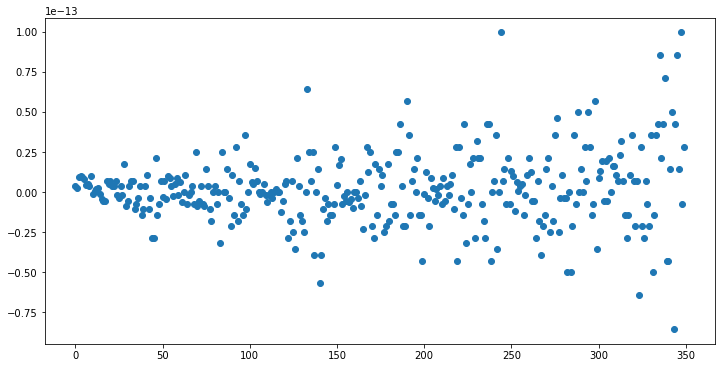

In [8]:
# Plot of difference of two ground state energies computed by full diagonalization and Lanczos.
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(RESULT['EIGVAL_FD'] - RESULT['EIGVAL_LC'], marker='o', linestyle='none')
plt.show()

# There is no meaningful difference in groundstate energies.

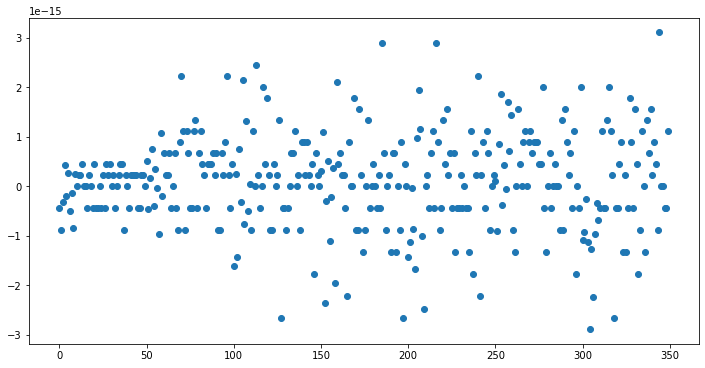

In [199]:
# Plot LOSS_EIGVECS
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(RESULT['LOSS_EIGVECS'], marker='o', linestyle='none')
plt.show()

# There is no meaningful difference in LOSS_EIGVECS

**Due to the degeneracy, one can have different eigenvector for Lanczos method or the state with an opposite phase might occur.
Hence the Lanczsos method should be used for quick check of groundstate energies and corresponding eigenvector.
For exact calculation, full diagonalization must be applied.**

In [9]:
Ham_xy = qxy.generate_Hamiltonian(qxy.generate_full_basis(10), 1, 1)
_, vec_fulld = linalg.eigh(Ham_xy)
_, vec_lancz = eigsh(Ham_xy, k = 1, which = 'SA')

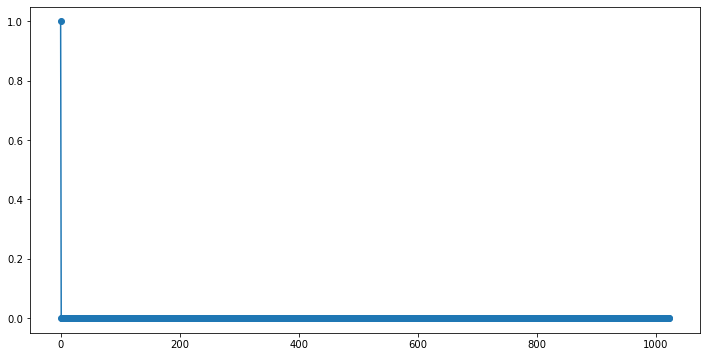

In [42]:
plt.plot(vec_fulld[:,0], marker = "o")
plt.show()

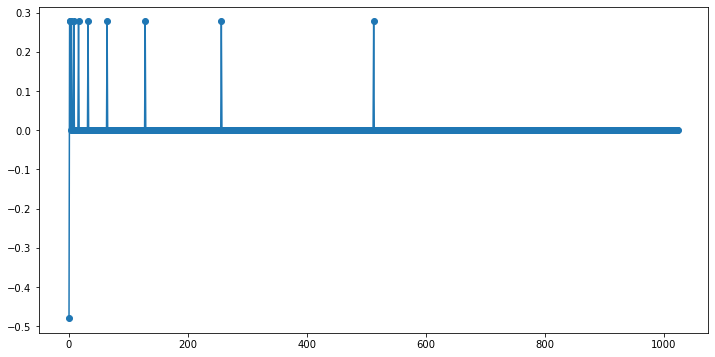

In [43]:
plt.plot(vec_lancz[:,0], marker = "o")
plt.show()

## Question 5
##### Compute the magnetization

In [39]:
# Parameters 
N = np.arange(5,12)
h = np.linspace(0.1,2.0, 50)
paramlist = list(itertools.product(N,h))

# Consider the Hamiltonian generated by Pauli matrices.
def process_algorithm_for_magnetization(paramlist):
    n = paramlist[0]
    h = paramlist[1]
    
    H = qxy.generate_Hamiltonian(qxy.generate_full_basis(n), 1, h)
    (eigval,eigvec) = linalg.eigh(H)
    
    return qxy.compute_magnetization(eigvec[:,0], qxy.generate_full_basis(n))

# Generate processes equal to the number of cores - 1
pool1 = multiprocessing.Pool(os.cpu_count() - 1)


start = time.time() # Time start
np.seterr('ignore') # Ignore errors
#-----------------------------------
# Distribute the parameter sets evenly across the cores
mag  = pool1.map(process_algorithm_for_magnetization, paramlist)
#-----------------------------------
end = time.time() # Time end
print('* Elapsed time: {}'.format(end - start)) # Print taken time

pool1.close()
pool1.terminate()
pool1.join()

* Elapsed time: 103.47014856338501


##### Plot magnetization with respect to field
**In the case of $J= 1$, the system with size varying from $5$ to $11$ is ferromagnet for $h$ larger than $1$.
The effect of $h\sigma_{i}^{z}$ is dominant.
For $h$ being smaller than $1$, the system still has positive magnetization.
But the effect of flipping consecutive spins suppress the spin alignment along the magnetic field.**

**The observation gives that the magnetization is equidistantly discretized.
That is because the allowed total angular momentum and the magnetization are proportional to each other.
For instance, with 5 spins system the possible total angular momentums are $5/2$, $3/2$, $1/2$.
Then there are three different magnetization.**

In [40]:
# Convert into dataframe
RESULT = pd.concat([pd.DataFrame(paramlist), pd.DataFrame(mag)], axis=1)
# Rename its column name
RESULT.columns = ['SIZE', 'FIELD', 'MAG']

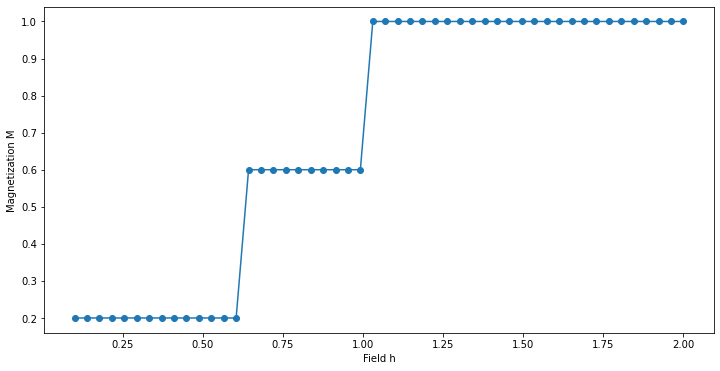

In [41]:
SUBSET = RESULT[RESULT['SIZE'] == 5]
plt.plot(SUBSET['FIELD'], SUBSET['MAG'], marker = "o")
plt.xlabel('Field h')
plt.ylabel('Magnetization M')
plt.show()

# plt.rcParams["figure.figsize"] = (12,6)
# for n in N:
#     SUBSET = RESULT[RESULT['SIZE'] == n]
#     plt.plot(SUBSET['FIELD'], SUBSET['MAG'], marker = "o")

# Question 6

In [26]:
# Parameters 
N = np.arange(5,12)
h = np.linspace(0.1,2.0,50)
paramlist = list(itertools.product(N,h))

# Consider the Hamiltonian generated by Pauli matrices.
def process_algorithm_for_connected_correlation(paramlist):
    n = paramlist[0]
    h = paramlist[1]
    
    H = qxy.generate_Hamiltonian_with_Pauli_matrices(n, 1, h)
    (eigval,eigvec) = linalg.eigh(H)
    
    G = qxy.compute_correlation(eigvec[:,0], qxy.generate_full_basis(n), 1)
    M = qxy.compute_magnetization(eigvec[:,0], qxy.generate_full_basis(n))
    return G - M**2

# Generate processes equal to the number of cores - 1
pool1 = multiprocessing.Pool(os.cpu_count() - 1)

start = time.time() # Time start
np.seterr('ignore') # Ignore errors
#-----------------------------------
# Distribute the parameter sets evenly across the cores
ccr  = pool1.map(process_algorithm_for_connected_correlation, paramlist)
#-----------------------------------
end = time.time() # Time end
print('* Elapsed time: {}'.format(end - start)) # Print taken time

pool1.close()
pool1.terminate()
pool1.join()

* Elapsed time: 153.16012954711914


##### Plot connected correlation with respect to field
**Since the connected correlation is zero for $h$ larger than $1$, there is no fluctation around the mean magnetization $M = 1$.
However there exists a fluctuation in magnetization for $h$ smaller than $1$ due to the flipping of consecutive spins.**

In [27]:
# Convert into dataframe
RESULT = pd.concat([pd.DataFrame(paramlist), pd.DataFrame(ccr)], axis=1)
# Rename its column name
RESULT.columns = ['SIZE', 'FIELD', 'ConnectedCOR']

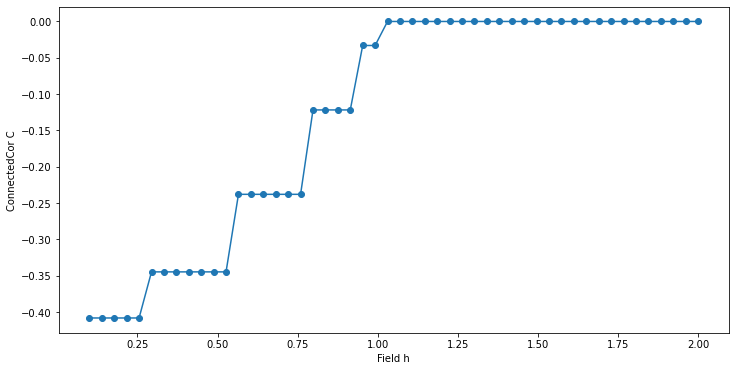

In [33]:
SUBSET = RESULT[RESULT['SIZE'] == 11]
plt.plot(SUBSET['FIELD'], SUBSET['ConnectedCOR'], marker = "o")
plt.xlabel('Field h')
plt.ylabel('ConnectedCor C')
plt.show()

# plt.rcParams["figure.figsize"] = (12,6)
# for n in N:
#     SUBSET = RESULT[RESULT['SIZE'] == n]
#     plt.plot(SUBSET['FIELD'], SUBSET['ConnectedCOR'], marker = "o")